In [17]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Train a Mario-playing RL Agent

**Authors:** [Yuansong Feng](https://github.com/YuansongFeng)_, [Suraj Subramanian](https://github.com/suraj813)_, [Howard Wang](https://github.com/hw26)_, [Steven Guo](https://github.com/GuoYuzhang)_.


This tutorial walks you through the fundamentals of Deep Reinforcement
Learning. At the end, you will implement an AI-powered Mario (using
[Double Deep Q-Networks](https://arxiv.org/pdf/1509.06461.pdf)_) that
can play the game by itself.

Although no prior knowledge of RL is necessary for this tutorial, you
can familiarize yourself with these RL
[concepts](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)_,
and have this handy
[cheatsheet](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N)_
as your companion. The full code is available
[here](https://github.com/yuansongFeng/MadMario/)_.

.. figure:: /_static/img/mario.gif
   :alt: mario


%%bash
pip install gym-super-mario-bros==7.4.0
pip install tensordict==0.3.0
pip install torchrl==0.3.0

In [18]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

## RL Definitions

**Environment** The world that an agent interacts with and learns from.

**Action** $a$ : How the Agent responds to the Environment. The
set of all possible Actions is called *action-space*.

**State** $s$ : The current characteristic of the Environment. The
set of all possible States the Environment can be in is called
*state-space*.

**Reward** $r$ : Reward is the key feedback from Environment to
Agent. It is what drives the Agent to learn and to change its future
action. An aggregation of rewards over multiple time steps is called
**Return**.

**Optimal Action-Value function** $Q^*(s,a)$ : Gives the expected
return if you start in state $s$, take an arbitrary action
$a$, and then for each future time step take the action that
maximizes returns. $Q$ can be said to stand for the “quality” of
the action in a state. We try to approximate this function.




## Environment

### Initialize Environment

In Mario, the environment consists of tubes, mushrooms and other
components.

When Mario makes an action, the environment responds with the changed
(next) state, reward and other info.




In [19]:
# Initialize Super Mario environment 
# (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    # For Gym versions earlier than 0.26, create the environment without specifying render mode
    env = gym_super_mario_bros.make("SuperMarioBros2-v1")
else:
    # For Gym versions 0.26 and later, create the environment with render mode set to 'rgb' and apply API compatibility
    env = gym_super_mario_bros.make("SuperMarioBros2-v1", render_mode='rgb', apply_api_compatibility=True)

# actions for very simple movement
# SIMPLE_MOVEMENT = [
#     ['NOOP'],
#     ['right'],
#     ['right', 'A'],
#     ['right', 'B'],
#     ['right', 'A', 'B'],
#     ['A'],
#     ['left'],
# ]

env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Reset the environment and get the initial state
state = env.reset()

# Perform an action (walking right) in the environment
next_state, reward, done, info = env.step(action=0)

# Print the resulting state shape, reward, termination status, and additional information
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


### Preprocess Environment

Environment data is returned to the agent in ``next_state``. As you saw
above, each state is represented by a ``[3, 240, 256]`` size array.
Often that is more information than our agent needs; for instance,
Mario’s actions do not depend on the color of the pipes or the sky!

We use **Wrappers** to preprocess environment data before sending it to
the agent.

``GrayScaleObservation`` is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
``[1, 240, 256]``

``ResizeObservation`` downsamples each observation into a square image.
New size: ``[1, 84, 84]``

``SkipFrame`` is a custom wrapper that inherits from ``gym.Wrapper`` and
implements the ``step()`` function. Because consecutive frames don’t
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

``FrameStack`` is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.




In [20]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

After applying the above wrappers to the environment, the final wrapped
state consists of 4 gray-scaled consecutive frames stacked together, as
shown above in the image on the left. Each time Mario makes an action,
the environment responds with a state of this structure. The structure
is represented by a 3-D array of size ``[4, 84, 84]``.

.. figure:: /_static/img/mario_env.png
   :alt: picture





## Agent

We create a class ``Mario`` to represent our agent in the game. Mario
should be able to:

-  **Act** according to the optimal action policy based on the current
   state (of the environment).

-  **Remember** experiences. Experience = (current state, current
   action, reward, next state). Mario *caches* and later *recalls* his
   experiences to update his action policy.

-  **Learn** a better action policy over time




In [21]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass

In the following sections, we will populate Mario’s parameters and
define his functions.




### Act

For any given state, an agent can choose to do the most optimal action
(**exploit**) or a random action (**explore**).

Mario randomly explores with a chance of ``self.exploration_rate``; when
he chooses to exploit, he relies on ``MarioNet`` (implemented in
``Learn`` section) to provide the most optimal action.




In [22]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print (f"Device: {self.device}")
        
        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

### Cache and Recall

These two functions serve as Mario’s “memory” process.

``cache()``: Each time Mario performs an action, he stores the
``experience`` to his memory. His experience includes the current
*state*, *action* performed, *reward* from the action, the *next state*,
and whether the game is *done*.

``recall()``: Mario randomly samples a batch of experiences from his
memory, and uses that to learn the game.




In [23]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

### Learn

Mario uses the [DDQN algorithm](https://arxiv.org/pdf/1509.06461)_
under the hood. DDQN uses two ConvNets - $Q_{online}$ and
$Q_{target}$ - that independently approximate the optimal
action-value function.

In our implementation, we share feature generator ``features`` across
$Q_{online}$ and $Q_{target}$, but maintain separate FC
classifiers for each. $\theta_{target}$ (the parameters of
$Q_{target}$) is frozen to prevent updating by backprop. Instead,
it is periodically synced with $\theta_{online}$ (more on this
later).

#### Neural Network



In [24]:
class MarioNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

#### TD Estimate & TD Target

Two values are involved in learning:

**TD Estimate** - the predicted optimal $Q^*$ for a given state
$s$

\begin{align}{TD}_e = Q_{online}^*(s,a)\end{align}

**TD Target** - aggregation of current reward and the estimated
$Q^*$ in the next state $s'$

\begin{align}a' = argmax_{a} Q_{online}(s', a)\end{align}

\begin{align}{TD}_t = r + \gamma Q_{target}^*(s',a')\end{align}

Because we don’t know what next action $a'$ will be, we use the
action $a'$ maximizes $Q_{online}$ in the next state
$s'$.

Notice we use the
[@torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad)_
decorator on ``td_target()`` to disable gradient calculations here
(because we don’t need to backpropagate on $\theta_{target}$).




In [25]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

#### Updating the model

As Mario samples inputs from his replay buffer, we compute $TD_t$
and $TD_e$ and backpropagate this loss down $Q_{online}$ to
update its parameters $\theta_{online}$ ($\alpha$ is the
learning rate ``lr`` passed to the ``optimizer``)

\begin{align}\theta_{online} \leftarrow \theta_{online} + \alpha \nabla(TD_e - TD_t)\end{align}

$\theta_{target}$ does not update through backpropagation.
Instead, we periodically copy $\theta_{online}$ to
$\theta_{target}$

\begin{align}\theta_{target} \leftarrow \theta_{online}\end{align}





In [26]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

#### Save checkpoint




In [27]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

#### Putting it all together




In [28]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logging




In [29]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

## Let’s play!

In this example we run the training loop for 40 episodes, but for Mario to truly learn the ways of
his world, we suggest running the loop for at least 40,000 episodes!




**Checking if CUDA is available**

In [30]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

Using CUDA: True



Device: cuda


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 0 - Step 739 - Epsilon 0.9998152670421141 - Mean Reward 1981.0 - Mean Length 739.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 7.448 - Time 2024-02-29T11:40:04


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 20 - Step 22015 - Epsilon 0.994511367199336 - Mean Reward 1261.476 - Mean Length 1048.333 - Mean Loss 0.223 - Mean Q Value 0.727 - Time Delta 234.508 - Time 2024-02-29T11:43:59


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 40 - Step 51877 - Epsilon 0.9871144867220536 - Mean Reward 1305.366 - Mean Length 1265.293 - Mean Loss 0.373 - Mean Q Value 2.104 - Time Delta 365.563 - Time 2024-02-29T11:50:04


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 60 - Step 83158 - Epsilon 0.9794251093096699 - Mean Reward 1288.689 - Mean Length 1363.246 - Mean Loss 0.472 - Mean Q Value 3.285 - Time Delta 422.335 - Time 2024-02-29T11:57:07


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 80 - Step 108630 - Epsilon 0.9732079458934535 - Mean Reward 1266.988 - Mean Length 1341.111 - Mean Loss 0.545 - Mean Q Value 4.363 - Time Delta 359.232 - Time 2024-02-29T12:03:06


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 100 - Step 137515 - Epsilon 0.966205480842705 - Mean Reward 1265.02 - Mean Length 1367.76 - Mean Loss 0.605 - Mean Q Value 5.258 - Time Delta 410.105 - Time 2024-02-29T12:09:56


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 120 - Step 164419 - Epsilon 0.9597285881754501 - Mean Reward 1278.6 - Mean Length 1424.04 - Mean Loss 0.72 - Mean Q Value 6.858 - Time Delta 381.853 - Time 2024-02-29T12:16:18


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 140 - Step 196705 - Epsilon 0.9520133167042294 - Mean Reward 1297.87 - Mean Length 1448.28 - Mean Loss 0.777 - Mean Q Value 8.024 - Time Delta 459.816 - Time 2024-02-29T12:23:58


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 160 - Step 223173 - Epsilon 0.9457346397138492 - Mean Reward 1312.77 - Mean Length 1400.15 - Mean Loss 0.808 - Mean Q Value 8.917 - Time Delta 376.923 - Time 2024-02-29T12:30:14


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 180 - Step 247521 - Epsilon 0.9399954372270106 - Mean Reward 1332.42 - Mean Length 1388.91 - Mean Loss 0.824 - Mean Q Value 9.556 - Time Delta 347.122 - Time 2024-02-29T12:36:02


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 200 - Step 274652 - Epsilon 0.9336412561515389 - Mean Reward 1344.59 - Mean Length 1371.37 - Mean Loss 0.834 - Mean Q Value 10.117 - Time Delta 384.826 - Time 2024-02-29T12:42:26


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 220 - Step 299639 - Epsilon 0.9278272102589356 - Mean Reward 1344.1 - Mean Length 1352.2 - Mean Loss 0.853 - Mean Q Value 10.753 - Time Delta 353.472 - Time 2024-02-29T12:48:20


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 240 - Step 325649 - Epsilon 0.9218135860566143 - Mean Reward 1343.01 - Mean Length 1289.44 - Mean Loss 0.873 - Mean Q Value 11.396 - Time Delta 368.983 - Time 2024-02-29T12:54:29


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 260 - Step 357598 - Epsilon 0.9144801555321748 - Mean Reward 1367.71 - Mean Length 1344.25 - Mean Loss 0.881 - Mean Q Value 11.872 - Time Delta 451.625 - Time 2024-02-29T13:02:00


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 280 - Step 382351 - Epsilon 0.9088385966953179 - Mean Reward 1379.26 - Mean Length 1348.3 - Mean Loss 0.886 - Mean Q Value 12.129 - Time Delta 350.065 - Time 2024-02-29T13:07:51


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 300 - Step 411779 - Epsilon 0.9021768057514472 - Mean Reward 1373.45 - Mean Length 1371.27 - Mean Loss 0.88 - Mean Q Value 12.209 - Time Delta 417.37 - Time 2024-02-29T13:14:48


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 320 - Step 445044 - Epsilon 0.8947051879378349 - Mean Reward 1438.13 - Mean Length 1454.05 - Mean Loss 0.868 - Mean Q Value 12.189 - Time Delta 473.021 - Time 2024-02-29T13:22:41


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 340 - Step 470102 - Epsilon 0.889117825876122 - Mean Reward 1456.05 - Mean Length 1444.53 - Mean Loss 0.856 - Mean Q Value 12.215 - Time Delta 357.228 - Time 2024-02-29T13:28:38


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 360 - Step 498344 - Epsilon 0.8828623181765163 - Mean Reward 1493.01 - Mean Length 1407.46 - Mean Loss 0.861 - Mean Q Value 12.357 - Time Delta 400.52 - Time 2024-02-29T13:35:19


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2024-02-29T11-39-57/mario_net_1.chkpt at step 500000
Episode 380 - Step 523910 - Epsilon 0.8772374976346495 - Mean Reward 1492.13 - Mean Length 1415.59 - Mean Loss 0.865 - Mean Q Value 12.669 - Time Delta 364.162 - Time 2024-02-29T13:41:23


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 400 - Step 541606 - Epsilon 0.8733651703641448 - Mean Reward 1481.28 - Mean Length 1298.27 - Mean Loss 0.876 - Mean Q Value 13.141 - Time Delta 250.27 - Time 2024-02-29T13:45:33


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 420 - Step 562709 - Epsilon 0.8687696465679853 - Mean Reward 1430.57 - Mean Length 1176.65 - Mean Loss 0.892 - Mean Q Value 13.763 - Time Delta 300.889 - Time 2024-02-29T13:50:34


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 440 - Step 583999 - Epsilon 0.8641579034356062 - Mean Reward 1392.25 - Mean Length 1138.97 - Mean Loss 0.91 - Mean Q Value 14.216 - Time Delta 303.699 - Time 2024-02-29T13:55:38


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 460 - Step 605674 - Epsilon 0.8594879113986515 - Mean Reward 1356.63 - Mean Length 1073.3 - Mean Loss 0.927 - Mean Q Value 14.569 - Time Delta 309.998 - Time 2024-02-29T14:00:48


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 480 - Step 629276 - Epsilon 0.8544314348849887 - Mean Reward 1375.1 - Mean Length 1053.66 - Mean Loss 0.949 - Mean Q Value 14.984 - Time Delta 336.151 - Time 2024-02-29T14:06:24


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 500 - Step 652808 - Epsilon 0.8494195709789697 - Mean Reward 1463.49 - Mean Length 1112.02 - Mean Loss 0.976 - Mean Q Value 15.456 - Time Delta 337.279 - Time 2024-02-29T14:12:01


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 520 - Step 672916 - Epsilon 0.8451602530279864 - Mean Reward 1483.77 - Mean Length 1102.07 - Mean Loss 0.997 - Mean Q Value 15.679 - Time Delta 288.404 - Time 2024-02-29T14:16:50


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 540 - Step 690105 - Epsilon 0.8415361800279467 - Mean Reward 1493.94 - Mean Length 1061.06 - Mean Loss 1.015 - Mean Q Value 15.937 - Time Delta 246.241 - Time 2024-02-29T14:20:56


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 560 - Step 707930 - Epsilon 0.8377944272424065 - Mean Reward 1485.45 - Mean Length 1022.56 - Mean Loss 1.031 - Mean Q Value 16.377 - Time Delta 253.843 - Time 2024-02-29T14:25:10


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 580 - Step 725333 - Epsilon 0.8341573105129991 - Mean Reward 1485.01 - Mean Length 960.57 - Mean Loss 1.051 - Mean Q Value 16.828 - Time Delta 248.516 - Time 2024-02-29T14:29:18


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 600 - Step 747112 - Epsilon 0.8296278739443571 - Mean Reward 1444.33 - Mean Length 943.04 - Mean Loss 1.059 - Mean Q Value 17.164 - Time Delta 312.188 - Time 2024-02-29T14:34:30


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 620 - Step 763323 - Epsilon 0.8262724031931055 - Mean Reward 1442.94 - Mean Length 904.07 - Mean Loss 1.074 - Mean Q Value 17.637 - Time Delta 231.26 - Time 2024-02-29T14:38:22


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 640 - Step 783571 - Epsilon 0.8221003800651964 - Mean Reward 1481.53 - Mean Length 934.66 - Mean Loss 1.092 - Mean Q Value 18.273 - Time Delta 289.944 - Time 2024-02-29T14:43:12


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 660 - Step 807004 - Epsilon 0.8172983892773451 - Mean Reward 1526.11 - Mean Length 990.74 - Mean Loss 1.095 - Mean Q Value 18.62 - Time Delta 335.911 - Time 2024-02-29T14:48:47


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 680 - Step 825836 - Epsilon 0.8134595916006349 - Mean Reward 1568.78 - Mean Length 1005.03 - Mean Loss 1.101 - Mean Q Value 18.883 - Time Delta 270.259 - Time 2024-02-29T14:53:18


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 700 - Step 844742 - Epsilon 0.8096238463267683 - Mean Reward 1608.61 - Mean Length 976.3 - Mean Loss 1.119 - Mean Q Value 19.148 - Time Delta 271.111 - Time 2024-02-29T14:57:49


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 720 - Step 866011 - Epsilon 0.8053302984423434 - Mean Reward 1600.07 - Mean Length 1026.88 - Mean Loss 1.126 - Mean Q Value 19.37 - Time Delta 304.808 - Time 2024-02-29T15:02:54


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 740 - Step 881211 - Epsilon 0.8022758500534907 - Mean Reward 1561.26 - Mean Length 976.4 - Mean Loss 1.13 - Mean Q Value 19.332 - Time Delta 218.321 - Time 2024-02-29T15:06:32


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 760 - Step 902370 - Epsilon 0.7980432155048989 - Mean Reward 1573.07 - Mean Length 953.66 - Mean Loss 1.146 - Mean Q Value 19.63 - Time Delta 302.163 - Time 2024-02-29T15:11:34


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 780 - Step 924909 - Epsilon 0.7935590862731916 - Mean Reward 1600.37 - Mean Length 990.73 - Mean Loss 1.15 - Mean Q Value 19.79 - Time Delta 322.724 - Time 2024-02-29T15:16:57


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 800 - Step 939071 - Epsilon 0.7907544578005221 - Mean Reward 1575.62 - Mean Length 943.29 - Mean Loss 1.143 - Mean Q Value 19.862 - Time Delta 203.464 - Time 2024-02-29T15:20:20


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 820 - Step 958321 - Epsilon 0.7869580938251234 - Mean Reward 1651.79 - Mean Length 923.1 - Mean Loss 1.155 - Mean Q Value 20.102 - Time Delta 277.017 - Time 2024-02-29T15:24:57


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 840 - Step 975368 - Epsilon 0.783611411177686 - Mean Reward 1688.65 - Mean Length 941.57 - Mean Loss 1.169 - Mean Q Value 20.605 - Time Delta 244.683 - Time 2024-02-29T15:29:02


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 860 - Step 993976 - Epsilon 0.7799745164138555 - Mean Reward 1636.81 - Mean Length 916.06 - Mean Loss 1.172 - Mean Q Value 20.77 - Time Delta 266.679 - Time 2024-02-29T15:33:29


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


MarioNet saved to checkpoints/2024-02-29T11-39-57/mario_net_2.chkpt at step 1000000
Episode 880 - Step 1009838 - Epsilon 0.7768876516090392 - Mean Reward 1543.64 - Mean Length 849.29 - Mean Loss 1.181 - Mean Q Value 21.154 - Time Delta 228.111 - Time 2024-02-29T15:37:17


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 900 - Step 1027530 - Epsilon 0.7734590650056219 - Mean Reward 1518.03 - Mean Length 884.59 - Mean Loss 1.206 - Mean Q Value 21.702 - Time Delta 254.194 - Time 2024-02-29T15:41:31


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 920 - Step 1039536 - Epsilon 0.7711410078964139 - Mean Reward 1422.63 - Mean Length 812.15 - Mean Loss 1.217 - Mean Q Value 22.145 - Time Delta 173.433 - Time 2024-02-29T15:44:24


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 940 - Step 1058274 - Epsilon 0.7675370453657684 - Mean Reward 1462.99 - Mean Length 829.06 - Mean Loss 1.231 - Mean Q Value 22.425 - Time Delta 269.41 - Time 2024-02-29T15:48:54


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 960 - Step 1074151 - Epsilon 0.764496536829132 - Mean Reward 1467.54 - Mean Length 801.75 - Mean Loss 1.248 - Mean Q Value 22.856 - Time Delta 228.846 - Time 2024-02-29T15:52:43


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 980 - Step 1091929 - Epsilon 0.7611062711456703 - Mean Reward 1530.99 - Mean Length 820.91 - Mean Loss 1.264 - Mean Q Value 23.246 - Time Delta 255.526 - Time 2024-02-29T15:56:58


/home/rinzler/github/Mario_RL/env/lib/python3.10/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 999 - Step 1104258 - Epsilon 0.7587639626928099 - Mean Reward 1561.75 - Mean Length 777.35 - Mean Loss 1.281 - Mean Q Value 23.599 - Time Delta 191.607 - Time 2024-02-29T16:00:10


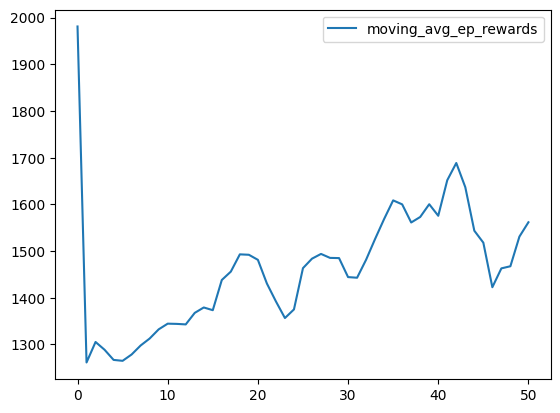

In [31]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 1000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Render the game frame
        env.render()
        
        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)
        
# Close the environment after training is done
env.close()

## Conclusion

In this tutorial, we saw how we can use PyTorch to train a game-playing AI. You can use the same methods
to train an AI to play any of the games at the [OpenAI gym](https://gym.openai.com/)_. Hope you enjoyed this tutorial, feel free to reach us at
[our github](https://github.com/yuansongFeng/MadMario/)_!



In [32]:
# import gym
# import torch
# from nes_py.wrappers import JoypadSpace
# from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# from pathlib import Path
# from my_mario_model import MarioNet  # Replace 'my_mario_model' with your model module

# def load_model(checkpoint_path):
#     model = MarioNet(input_dim=(4, 84, 84), output_dim=7)  # Adjust parameters as per your model
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model'])
#     model.eval()
#     return model

# def play_mario(model, episodes=1):
#     env = gym_super_mario_bros.make("SuperMarioBros-v1")
#     env = JoypadSpace(env, SIMPLE_MOVEMENT)

#     for episode in range(episodes):
#         state = env.reset()
#         done = False
#         total_reward = 0

#         while not done:
#             # Preprocess the state if necessary
#             state = preprocess_state(state)

#             # Convert state to tensor and unsqueeze to add batch dimension
#             state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

#             # Get action from the model
#             with torch.no_grad():
#                 action_values = model(state)
#                 action = torch.argmax(action_values, dim=1).item()

#             # Step the environment
#             next_state, reward, done, _ = env.step(action)
#             total_reward += reward
#             state = next_state

#         print(f"Episode {episode + 1} completed with total reward: {total_reward}")

# def preprocess_state(state):
#     # Implement any necessary preprocessing steps here (e.g., resize, grayscale, etc.)
#     return state

# if __name__ == "__main__":
#     checkpoint_path = Path("checkpoints") / "mario_net_1.chkpt"  # Adjust path accordingly
#     model = load_model(checkpoint_path)
#     play_mario(model, episodes=5)  # Adjust number of episodes as needed
